https://medium.com/grabngoinfo/multivariate-time-series-forecasting-with-seasonality-and-holiday-effect-using-prophet-in-python-d5d4150eeb57

In [3]:
###### Step 1: Install and Import Libraries

# Get time series data
import yfinance as yf
# Prophet model for time series forecast
from prophet import Prophet
# Data processing
import numpy as np
import pandas as pd
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

[*********************100%***********************]  2 of 2 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2020-01-02 to 2021-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOOG    505 non-null    float64
 1   VTI     505 non-null    float64
dtypes: float64(2)
memory usage: 11.8 KB


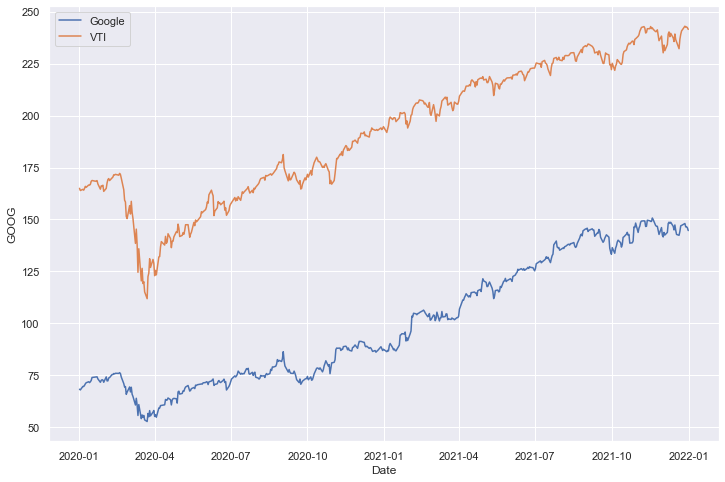

In [4]:
###### Step 2: Pull Data
# Data start date
start_date = '2020-01-02'
# Data end date. yfinance excludes the end date, so we need to add one day to the last day of data
end_date = '2022-01-01' 
# Date for splitting training and testing dataset
train_end_date = '2021-12-15'
# Pull close data from Yahoo Finance for the list of tickers
ticker_list = ['GOOG', 'VTI']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]
# Take a look at the data
data.head()
# Drop one level of the column names
data.columns = data.columns.droplevel(0)
# Take a look at the data
data.head()
# Information on the dataframe
data.info()
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data.index, y=data['GOOG'])
sns.lineplot(x=data.index, y=data['VTI'])
plt.legend(['Google', 'VTI'])

In [5]:
###### Step 3: Data Processing
# Change variable names
data = data.reset_index()
data.columns = ['ds', 'y', 'VTI']
# Take a look at the data
data.head()
# Check correlation
data.corrwith(data["y"])

y      1.000000
VTI    0.967116
dtype: float64

In [6]:
###### Step 4: Train Test Split
# Train test split
train = data[data['ds'] <= train_end_date]
test = data[data['ds'] > train_end_date]
# Check the shape of the dataset
print(train.shape)
print(test.shape)
# Check the start and end time of the training and testing dataset
print('The start time of the training dataset is ', train['ds'].min())
print('The end time of the training dataset is ', train['ds'].max())
print('The start time of the testing dataset is ', test['ds'].min())
print('The end time of the testing dataset is ', test['ds'].max())

(494, 3)
(11, 3)
The start time of the training dataset is  2020-01-02 00:00:00
The end time of the training dataset is  2021-12-15 00:00:00
The start time of the testing dataset is  2021-12-16 00:00:00
The end time of the testing dataset is  2021-12-31 00:00:00


17:19:39 - cmdstanpy - INFO - Chain [1] start processing
17:19:39 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the baseline model is 4.288028859442324
The MAPE for the baseline model is 0.02960665649561778


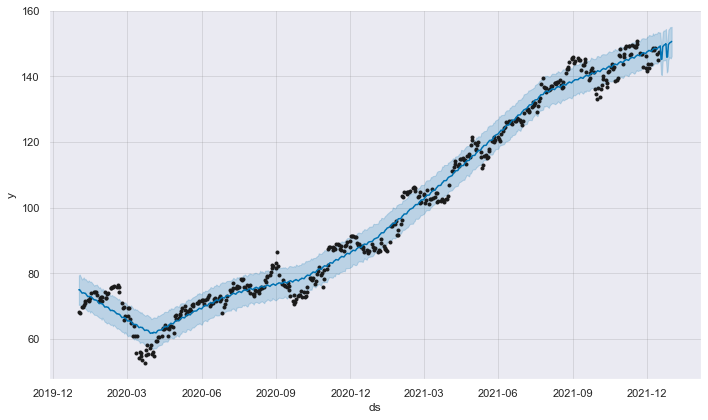

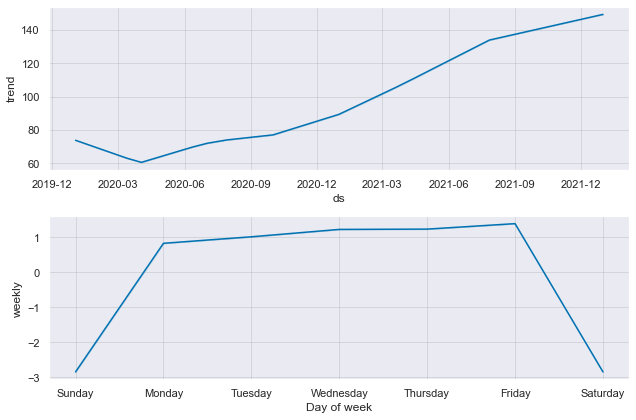

In [7]:
###### Step 5: Baseline Model
# Use the default hyperparameters to initiate the Prophet model
model_baseline = Prophet()
# Fit the model on the training dataset
model_baseline.fit(train)
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=16)
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart
# Visualize the forecast components
model_baseline.plot_components(forecast_baseline);
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')
# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

17:19:46 - cmdstanpy - INFO - Chain [1] start processing
17:19:46 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the seasonality model is 2.9913761553609985
The MAPE for the seasonality model is 0.02047163271274602


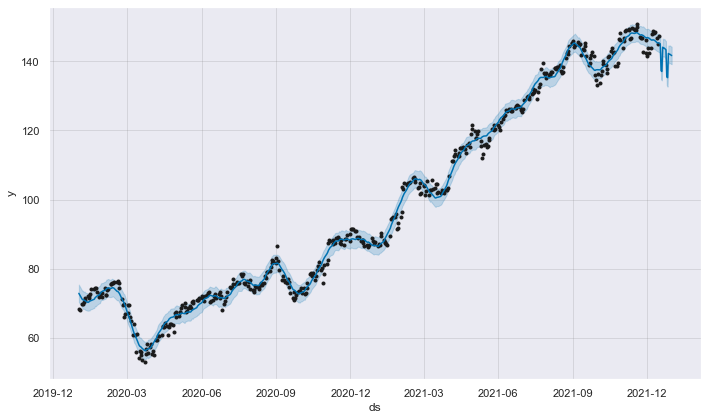

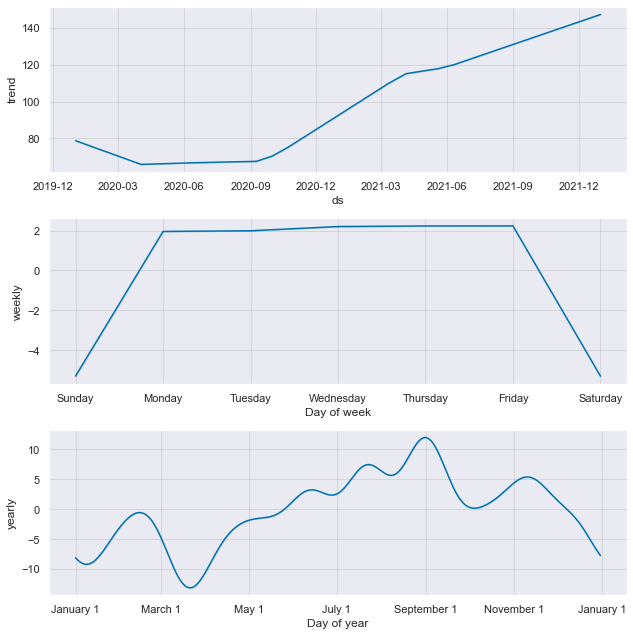

In [8]:
###### Step 6: Add Seasonality to Baseline Model
# Add seasonality
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True)
# Fit the model on the training dataset
model_season.fit(train)
# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=16)
# Make prediction
forecast_season = model_season.predict(future_season)
# Visualize the forecast
model_season.plot(forecast_season); # Add semi-colon to remove the duplicated chart
# Visualize the forecast components
model_season.plot_components(forecast_season);
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')
# Check MAPE value
performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

17:19:55 - cmdstanpy - INFO - Chain [1] start processing
17:19:55 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the multivariate model is 3.3904375178076096
The MAPE for the multivariate model is 0.023188504719350946


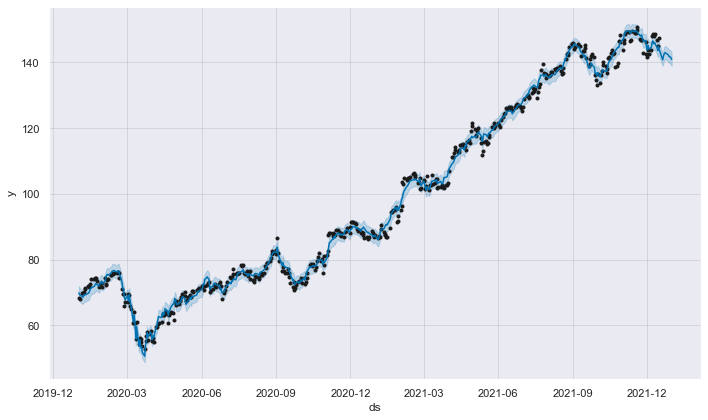

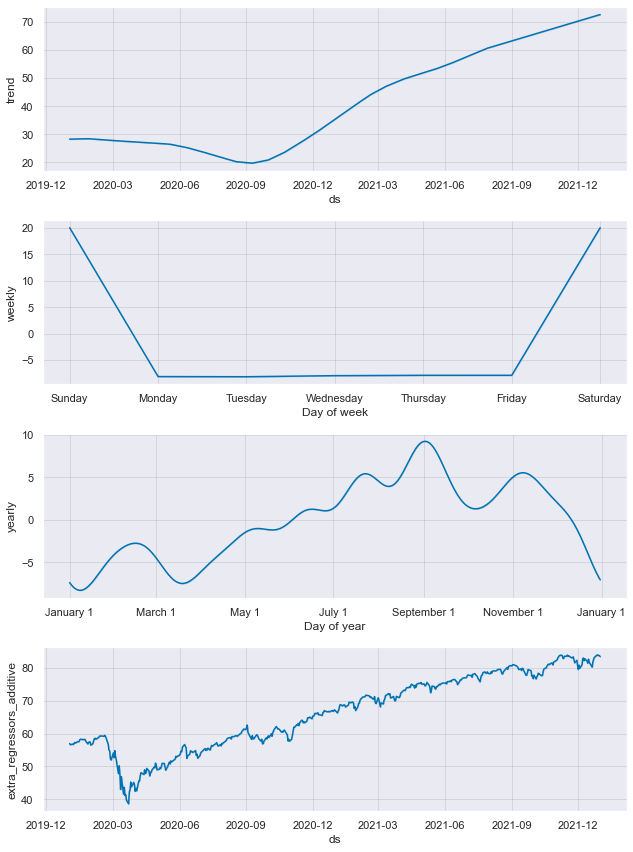

In [9]:
###### Step 7: Multivariate Model
# Add seasonality 
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)
# Add regressor
model_multivariate.add_regressor('VTI', standardize=False)
# Fit the model on the training dataset
model_multivariate.fit(train)
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=16)
# Append the regressor values
future_multivariate = pd.merge(future_multivariate, data[['ds', 'VTI']], on='ds', how='inner')
# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')
# Check the data
future_multivariate.tail(10)
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)
# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')
# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

17:20:10 - cmdstanpy - INFO - Chain [1] start processing
17:20:10 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the holiday/event model is 2.806323672122819
The MAPE for the holiday/event model is 0.01919675037958863


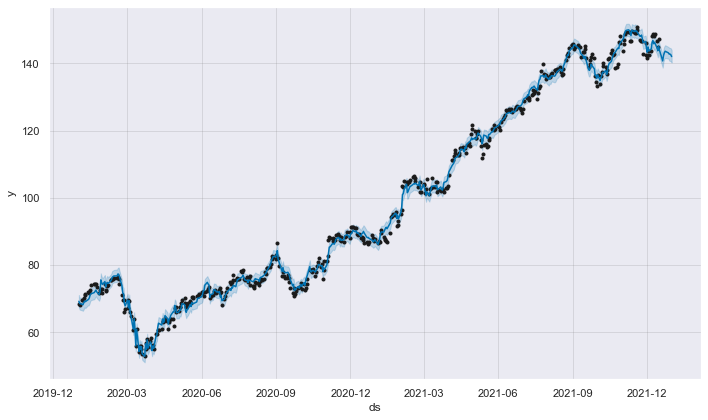

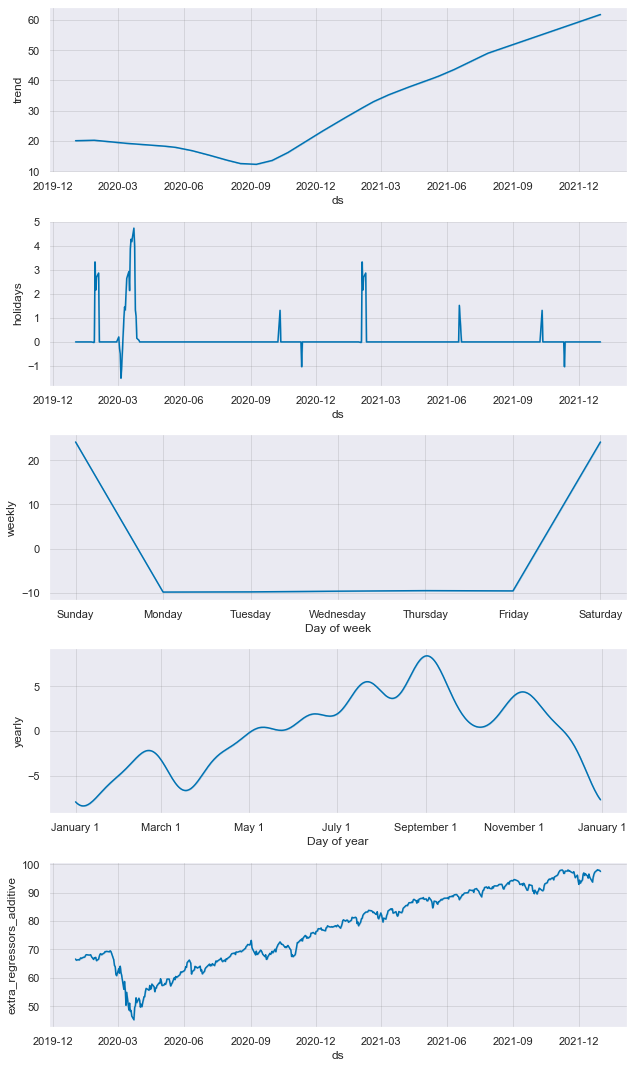

In [10]:
###### Step 8: Model with Holiday Effect and Event Effect
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,    
})
# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,    
})
# Combine all events
events = pd.concat((COVID, superbowl))
# Take a look at the events data
events
# Add holidays
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=events)
# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='US')
# Add regressor
model_holiday.add_regressor('VTI', standardize=False)
# Fit the model on the training dataset
model_holiday.fit(train)
# All the holidays and events
model_holiday.train_holiday_names
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=16)
# Append the regressor values
future_holiday = pd.merge(future_holiday, data[['ds', 'VTI']], on='ds', how='inner')
# Fill the missing values with the previous value
future_holiday = future_holiday.fillna(method='ffill')
# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)
# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart
# Visualize the forecast components
model_holiday.plot_components(forecast_holiday);
# Merge actual and predicted values
performance_holiday = pd.merge(test, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')
# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')